In [ ]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='keras')

## Data Preparation

In [2]:
import kagglehub

# Download latest version
test_path = kagglehub.dataset_download("naykrit/animal-classification")
train_path = path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to test files:", test_path)
print("Path to train files:", train_path)

Path to test files: /kaggle/input/animal-classification
Path to train files: /kaggle/input/animal-image-dataset-90-different-animals


In [3]:
def load_images_from_directory(directory, sel, image_size=(150, 150)):
    images = []
    labels = []
    class_names = os.listdir(directory)
    
    for class_name in sel:
        class_path = os.path.join(directory, class_name)
        
        if os.path.isdir(class_path):
            # Get all image files in the directory
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = image.load_img(img_path, target_size=image_size)
                    img_array = image.img_to_array(img) / 255.0  # Normalize the image
                    images.append(img_array)
                    labels.append(sel.index(class_name))  # Index of class_name as label
    
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [4]:
train_dir = train_path + '/animals/animals'  
test_dir = test_path + '/test_set'
class_names = ["dog", "cat", "elephant", "lion", "tiger"]
num_classes = len(class_names)

# Load the training and testing data
print("Loading training data...")
train_images, train_labels = load_images_from_directory(train_dir, sel = class_names)
print("Loading test data...")
test_images, test_labels = load_images_from_directory(test_dir, sel = class_names)
train_images, e_images, train_labels, e_labels = train_test_split(train_images, train_labels, stratify=train_labels, test_size=0.2, random_state=42)

Loading training data...
Loading test data...


In [5]:
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        print(f"Class {class_name}: {num_images} images")

Class dog: 60 images
Class cat: 60 images
Class elephant: 60 images
Class lion: 60 images
Class tiger: 60 images


In [6]:
def show_example_images(images, labels, class_names, target_class, num_images=5):
    class_index = class_names.index(target_class)  # Get the index for the target class
    class_images = [images[i] for i in range(len(images)) if labels[i] == class_index]
    
    # Randomly select a number of images from the filtered class
    selected_images = random.sample(class_images, min(num_images, len(class_images)))
    
    # Plot the selected images
    plt.figure(figsize=(15, 10))
    for i, img in enumerate(selected_images):
        plt.subplot(1, num_images, i+1)
        
        # Reverse normalization
        img = img * 255.0  # Reverse normalization to show the actual image
        img = img.astype(np.uint8)
        
        # Plot each image
        plt.imshow(img)
        plt.title(f"Label: {target_class}")
        plt.axis('off')  
    
    plt.show()

In [7]:
show_example_images(train_images, train_labels, class_names, target_class="dog", num_images=5)

In [8]:
show_example_images(train_images, train_labels, class_names, target_class="cat", num_images=5)

In [9]:
show_example_images(train_images, train_labels, class_names, target_class="elephant", num_images=5)

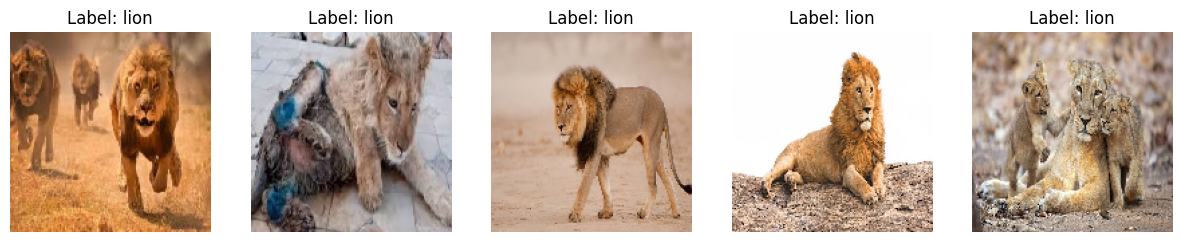

In [10]:
show_example_images(train_images, train_labels, class_names, target_class="lion", num_images=5)

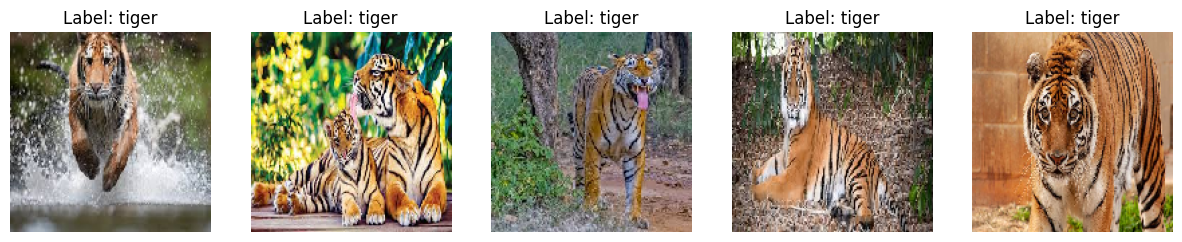

In [11]:
show_example_images(train_images, train_labels, class_names, target_class="tiger", num_images=5)

## Plot Performance

In [12]:
def plot_performance(history):
    # Check available keys
    print("Available keys in history.history:", history.history.keys())
    
    # Use 'accuracy' if available, otherwise fall back to 'acc'
    train_acc_key = 'accuracy' if 'accuracy' in history.history else 'acc'
    val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'
    
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history[train_acc_key], label='Train Accuracy')
    plt.plot(history.history[val_acc_key], label='Test Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

## Visualize Misclassified Images

In [13]:
def show_misclassified_images(images, true_labels, pred_labels, class_names, num_images=5):
    misclassified_idx = np.where(true_labels != pred_labels)[0]
    if len(misclassified_idx) == 0:
        print("No misclassified images found.")
        return
    
    selected_idx = np.random.choice(misclassified_idx, min(num_images, len(misclassified_idx)), replace=False)
    
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(selected_idx):
        plt.subplot(1, num_images, i+1)
        img = images[idx] * 255.0  # Reverse normalization
        img = img.astype(np.uint8)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}")
        plt.axis('off')
    plt.show()


# 1 CNN Model

In [38]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the CNN
cnn_history = cnn_model.fit(
    train_images, train_labels,
    validation_data=(e_images, e_labels),
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - accuracy: 0.1414 - loss: 2.5258 - val_accuracy: 0.2000 - val_loss: 1.5928
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2903 - loss: 1.5675 - val_accuracy: 0.3333 - val_loss: 1.5263
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3082 - loss: 1.5161 - val_accuracy: 0.2667 - val_loss: 1.5355
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3749 - loss: 1.4120 - val_accuracy: 0.4333 - val_loss: 1.3549
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4296 - loss: 1.3839 - val_accuracy: 0.6000 - val_loss: 1.2167
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5303 - loss: 1.1946 - val_accuracy: 0.5667 - val_loss: 1.1570
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5065 - loss: 1.0904 - val_accuracy: 0.5667 - val_loss: 1.0934
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6094 - loss: 1.0731 - val_accuracy: 0.5500 - val_loss: 1.0757

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4971 - loss: 1.4481
Test Accuracy (CNN): 0.550000011920929
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
              precision    recall  f1-score   support

         dog       0.38      0.50      0.43        20
         cat       0.27      0.20      0.23        20
    elephant       0.52      0.70      0.60        20
        lion       0.75      0.45      0.56        20
       tiger       0.90      0.90      0.90        20

    accuracy                           0.55       100
   macro avg       0.56      0.55      0.54       100
weighted avg       0.56      0.55      0.54       100



Available keys in history.history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


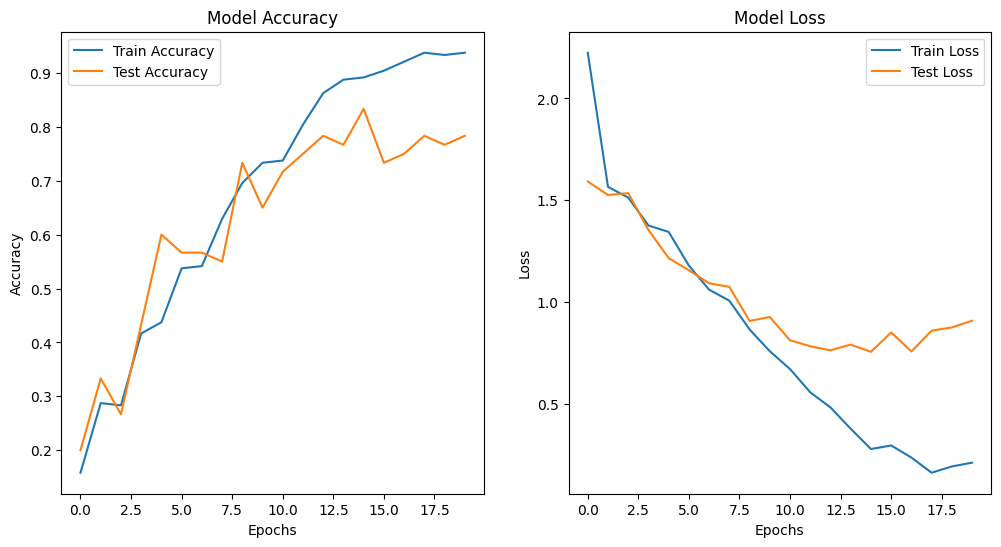

In [39]:
#Evaluation
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)
print(f"Test Accuracy (CNN): {test_acc}")

test_predictions = np.argmax(cnn_model.predict(test_images), axis=1)
print(classification_report(test_labels, test_predictions, target_names=class_names))
show_misclassified_images(test_images, test_labels, test_predictions, class_names)

plot_performance(cnn_history)

In [34]:
# Experiment : Data Augmentation for CNN
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

cnn_aug_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

cnn_aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train with Augmentation
cnn_aug_history = cnn_aug_model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    validation_data=(e_images, e_labels),
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 369ms/step - accuracy: 0.2514 - loss: 2.0752 - val_accuracy: 0.2833 - val_loss: 1.6002
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2165 - loss: 1.6073 - val_accuracy: 0.2000 - val_loss: 1.5763
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2717 - loss: 1.5692 - val_accuracy: 0.2500 - val_loss: 1.5298
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3073 - loss: 1.5590 - val_accuracy: 0.2667 - val_loss: 1.5846
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3414 - loss: 1.4868 - val_accuracy: 0.4667 - val_loss: 1.3671
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3799 - loss: 1.4398 - val_accuracy: 0.3833 - val_loss: 1.4970
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3564 - loss: 1.4121 - val_accuracy: 0.2833 - val_loss: 1.6302
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4036 - loss: 1.4132 - val_accuracy: 0.3667 - val_loss: 1.4117

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4917 - loss: 1.1918
Test Accuracy (CNN with Augmentation): 0.5600000023841858
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
              precision    recall  f1-score   support

         dog       0.30      0.40      0.34        20
         cat       0.25      0.15      0.19        20
    elephant       0.61      0.85      0.71        20
        lion       0.82      0.45      0.58        20
       tiger       0.86      0.95      0.90        20

    accuracy                           0.56       100
   macro avg       0.57      0.56      0.54       100
weighted avg       0.57      0.56      0.54       100



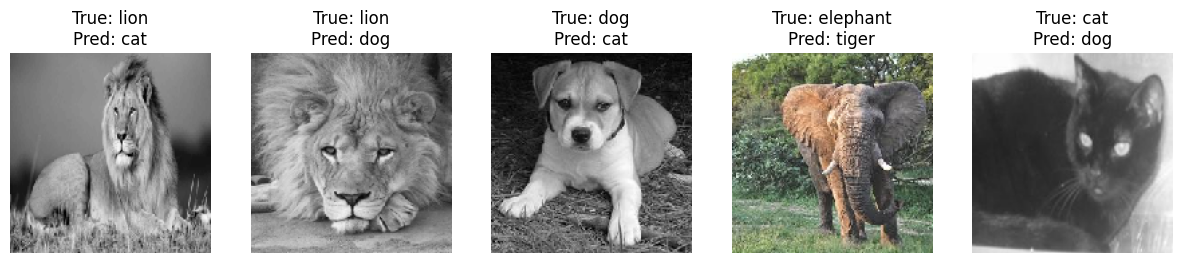

Available keys in history.history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


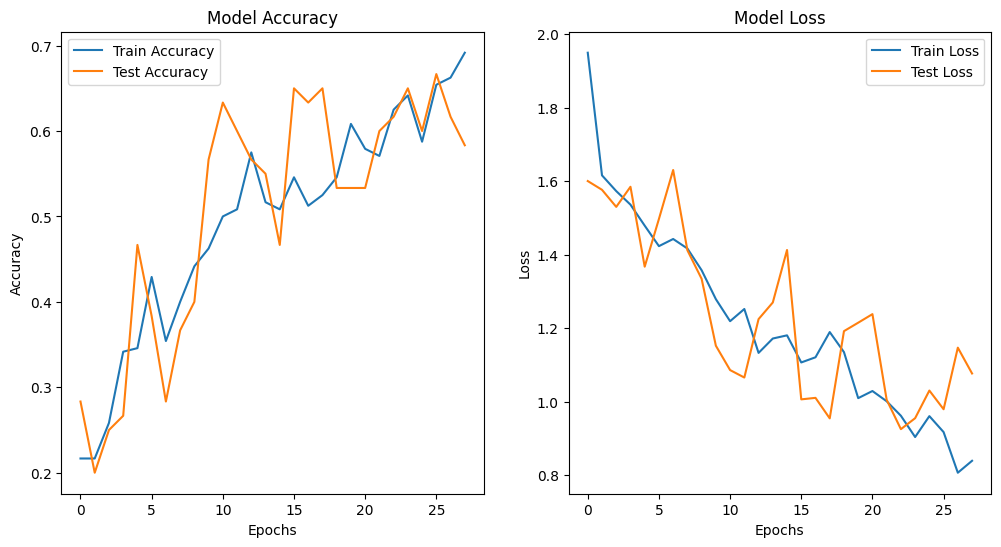

In [35]:
# Evaluation
test_loss_aug, test_acc_aug = cnn_aug_model.evaluate(test_images, test_labels)
print(f"Test Accuracy (CNN with Augmentation): {test_acc_aug}")

#Classification Report
cnn_aug_predictions = np.argmax(cnn_aug_model.predict(test_images), axis=1)
print(classification_report(test_labels, cnn_aug_predictions, target_names=class_names))


show_misclassified_images(test_images, test_labels, cnn_aug_predictions, class_names)

plot_performance(cnn_aug_history)

# 2 VGG16 Pretrain Model

In [18]:
# Pre-trained VGG16 Without Training
from tensorflow.keras.applications import VGG16

# Load VGG16 without top layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg_base.trainable = False  # Freeze the base model

# Build Model
vgg_no_train_model = models.Sequential([
    vgg_base,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

vgg_no_train_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Extract features (no training, just prediction)
vgg_no_train_model.fit(train_images, train_labels, epochs=1, batch_size=32, verbose=0)  # Dummy fit to build model

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7509 - loss: 0.9376
Test Accuracy (VGG16 No Training): 0.7599999904632568
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
              precision    recall  f1-score   support

         dog       0.52      0.60      0.56        20
         cat       0.79      0.95      0.86        20
    elephant       1.00      0.75      0.86        20
        lion       0.83      0.50      0.62        20
       tiger       0.77      1.00      0.87        20

    accuracy                           0.76       100
   macro avg       0.78      0.76      0.75       100
weighted avg       0.78      0.76      0.75       100



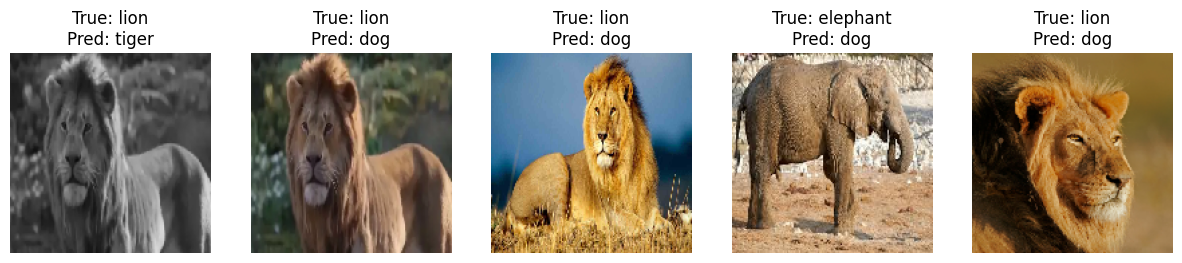

In [20]:
# Evaluation
test_loss_vgg, test_acc_vgg = vgg_no_train_model.evaluate(test_images, test_labels)
print(f"Test Accuracy (VGG16 No Training): {test_acc_vgg}")

# Classification Report
vgg_no_train_predictions = np.argmax(vgg_no_train_model.predict(test_images), axis=1)
print(classification_report(test_labels, vgg_no_train_predictions, target_names=class_names))
show_misclassified_images(test_images, test_labels, vgg_no_train_predictions, class_names)


# 3 Pretrain with additional tuning

In [22]:
# Pre-trained VGG16 with Fine-tuning
vgg_base_tune = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg_base_tune.trainable = True  # Allow fine-tuning

# Build Model
vgg_tune_model = models.Sequential([
    vgg_base_tune,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

vgg_tune_model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the Model
vgg_tune_history = vgg_tune_model.fit(
    train_images, train_labels,
    validation_data=(e_images, e_labels),
    epochs=15,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)],
    batch_size=32
)

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.1729 - loss: 1.9640 - val_accuracy: 0.3000 - val_loss: 1.5490
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.3552 - loss: 1.5434 - val_accuracy: 0.4500 - val_loss: 1.3988
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.5277 - loss: 1.2489 - val_accuracy: 0.6000 - val_loss: 1.2659
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.6221 - loss: 1.0852 - val_accuracy: 0.6833 - val_loss: 1.1215
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.6693 - loss: 0.9341 - val_accuracy: 0.7167 - val_loss: 0.9921
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.8416 - loss: 0.7280 - val_accuracy: 0.7667 - val_loss: 0.8611
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.8257 - loss: 0.6122 - val_accuracy: 0.8000 - val_loss: 0.7682
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.8490 - loss: 0.5162 - val_accuracy: 0.8000 - val_loss: 0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7716 - loss: 0.6046
Test Accuracy (VGG16 Fine-tuned): 0.8299999833106995
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
              precision    recall  f1-score   support

         dog       0.80      0.40      0.53        20
         cat       0.74      0.85      0.79        20
    elephant       0.80      1.00      0.89        20
        lion       0.86      0.90      0.88        20
       tiger       0.95      1.00      0.98        20

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.81       100
weighted avg       0.83      0.83      0.81       100



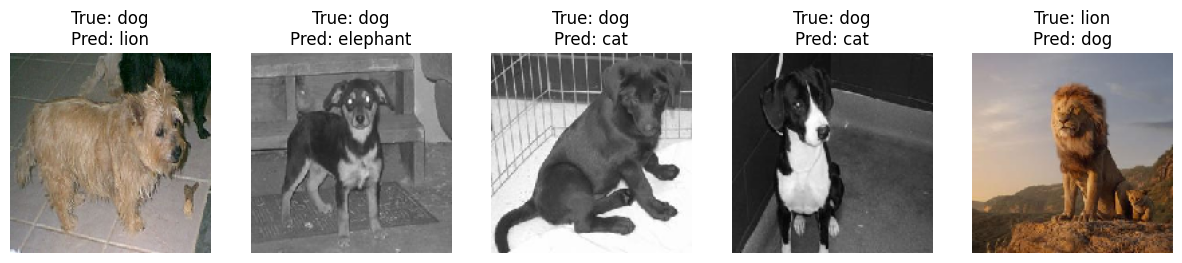

Available keys in history.history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


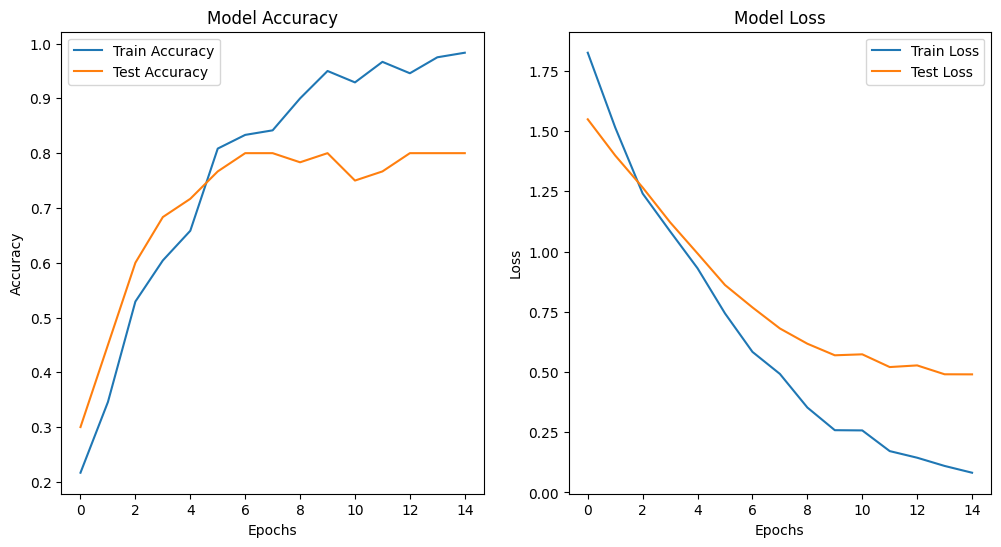

In [23]:
# Evaluate on Test Set
test_loss_tune, test_acc_tune = vgg_tune_model.evaluate(test_images, test_labels)
print(f"Test Accuracy (VGG16 Fine-tuned): {test_acc_tune}")


# Classification Report
vgg_tune_predictions = np.argmax(vgg_tune_model.predict(test_images), axis=1)
print(classification_report(test_labels, vgg_tune_predictions, target_names=class_names))
show_misclassified_images(test_images, test_labels, vgg_tune_predictions, class_names)

plot_performance(vgg_tune_history)

## Experiment Evaluation & Analysis

In [24]:
def evaluate_model(model, test_images, test_labels):
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f"Test accuracy: {test_acc:.4f}")
    return test_loss, test_acc

#### CNN vs CNN with Data Augmentation

In [40]:
evaluate_model(cnn_model, test_images, test_labels)
evaluate_model(cnn_aug_model, test_images, test_labels)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4971 - loss: 1.4481 
Test accuracy: 0.5500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4917 - loss: 1.1918 
Test accuracy: 0.5600


(1.0571061372756958, 0.5600000023841858)

#### CNN vs VGG16

In [41]:
evaluate_model(cnn_model, test_images, test_labels)
evaluate_model(vgg_no_train_model, test_images, test_labels)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4971 - loss: 1.4481 
Test accuracy: 0.5500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7509 - loss: 0.9376
Test accuracy: 0.7600


(0.9004685878753662, 0.7599999904632568)

#### VGG16 vs VGG16 with Additional Tuning

In [42]:
evaluate_model(vgg_no_train_model, test_images, test_labels)
evaluate_model(vgg_tune_model, test_images, test_labels)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7509 - loss: 0.9376
Test accuracy: 0.7600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7716 - loss: 0.6046
Test accuracy: 0.8300


(0.48374947905540466, 0.8299999833106995)

Summary : Accuracy ของ CNN และ CNN with Data Augmentation มีความใกล้เคียวกัน โดย  CNN with Data Augmentation มี accuracy มากกว่าเล็กน้อย แต่จะน้อยกว่า accuracy ของ VGG16 และ VGG16 with Additional Tuning มี accuracy ที่มากกว่าอย่างเห็นไดัชัด โดยจากการ train VGG16 with Additional Tuning จะมี Accuracy ที่มากที่สุดในmodelทั้งหมดที่ 83%

## Predict

In [28]:
def plot_prediction(model, img_path, class_names):
    # Load the image from the given path
    img = image.load_img(img_path, target_size=(150, 150))  # Resize to the same size the model expects
    # Convert the image to a numpy array and preprocess (normalize the pixel values)
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1] for model input
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (model expects [batch_size, height, width, channels])
    
    # Make the prediction
    predictions = model.predict(img_array)
    
    # For binary classification, the output is a single value
    if predictions.shape[1] == 1:
        predicted_class = class_names[1] if predictions[0] > 0.5 else class_names[0]  # Sigmoid threshold at 0.5
    else:
        predicted_class = class_names[np.argmax(predictions)]  # For multi-class, use argmax on softmax output

    # Plot the image and display the prediction
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')  
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


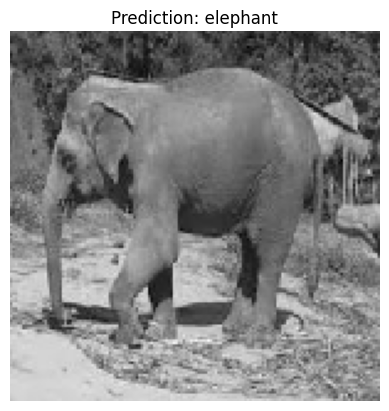

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


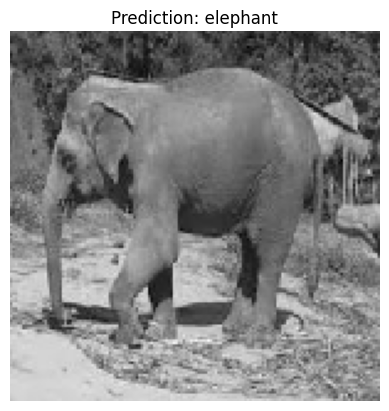

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


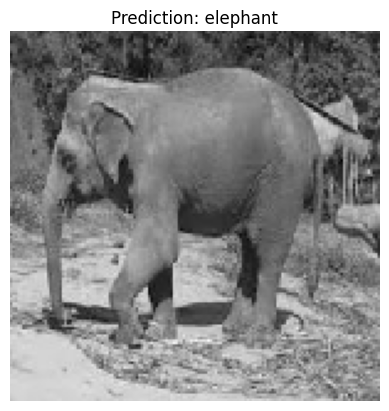

In [43]:
img_path ='/kaggle/input/animal-classification/test_set/elephant/elephant_12.jpg'
plot_prediction(vgg_tune_model, img_path, class_names)
plot_prediction(vgg_no_train_model, img_path, class_names)
plot_prediction(cnn_model, img_path, class_names)
plot_prediction(cnn_aug_model, img_path, class_names)
